In [1]:
import glob, copy, pywt
import scipy
import wfdb
from sklearn import svm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from collections import Counter
from ecgdetectors import Detectors
from read_data import ECGSample, ECGDataset
import random

# Load dataset

In [2]:
dataset = ECGDataset()

# Train val test split 50% 25% 25%

In [240]:
train= [ 101, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122, 124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]
test_val = [100, 103, 105, 111, 113, 117, 121, 123, 200, 202, 210, 212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]

random.shuffle(test_val)
test, val = test_val[:len(test_val)//2], test_val[len(test_val)//2:]

In [301]:
print(sum(train_y == 1))
print(sum(train_y == 2))
print(sum(train_y == 3))
print(sum(train_y == 4))
print(sum(train_y == 5))

45814
976
3788
414
8


In [241]:
train_x, train_y, test_x, test_y, val_x, val_y = dataset.get_train_test_sets(train, test, val)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(val_x.shape)
print(val_y.shape)

(51000, 70)
(51000,)
(24614, 70)
(24614,)
(25077, 70)
(25077,)


# Downsample majority class

In [311]:
from sklearn.utils import resample

df_train = pd.DataFrame(train_x)
df_train['y'] = train_y

df_majority = df[df.y==1]
df_minority = df[df.y!=1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=sum(train_y == 1)//10,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.y.value_counts()

1    4581
3    3788
2     976
4     414
5       8
Name: y, dtype: int64

In [326]:
from sklearn import preprocessing
c= np.array(df_downsampled.drop(['y'], axis = 1))
X_train_cnn = np.reshape(c, (c.shape[0], c.shape[1], 1), "A")
Y_train_cnn = preprocessing.label_binarize(np.array(df_downsampled.y), [1, 2, 3, 4, 5])


X_val_cnn = np.reshape(val_x, (val_x.shape[0], val_x.shape[1], 1), "A")
X_test_cnn = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1), "A")


Y_val_cnn = preprocessing.label_binarize(val_y, [1, 2, 3, 4, 5])
Y_test_cnn = preprocessing.label_binarize(test_y, [1, 2, 3, 4, 5])

# Build 1D CNN 


In [328]:
from keras.layers import Conv1D, Dense, Flatten, Dropout,MaxPooling1D
from keras.models import Sequential
from keras.utils import to_categorical
import keras

In [329]:
model = Sequential()
model.add(Conv1D(filters = 128, kernel_size = 7, activation = "relu", input_shape = (70, 1)))
model.add(MaxPooling1D(2))
model.add(Dropout(rate= 0.30))
model.add(Conv1D(filters = 64, kernel_size = 5, activation = "relu"))
model.add(MaxPooling1D(2))
model.add(Dropout(rate= 0.30))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(5, activation = 'sigmoid'))

model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy", keras.metrics.AUC()])

In [330]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 64, 128)           1024      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 32, 128)           0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 128)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 28, 64)            41024     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 14, 64)            0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 64)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 896)             

In [331]:
history = model.fit(X_train_cnn, Y_train_cnn, batch_size = 32, epochs=20, validation_data = (X_val_cnn, Y_val_cnn))

Train on 9767 samples, validate on 25077 samples
Epoch 1/20
9767/9767 [==============================] - 15s 2ms/step - loss: 0.5810 - accuracy: 0.7822 - auc_5: 0.8901 - val_loss: 0.6426 - val_accuracy: 0.7460 - val_auc_5: 0.8977
Epoch 2/20
9767/9767 [==============================] - 14s 1ms/step - loss: 0.3101 - accuracy: 0.9024 - auc_5: 0.9411 - val_loss: 0.7180 - val_accuracy: 0.8157 - val_auc_5: 0.8758
Epoch 3/20
9767/9767 [==============================] - 15s 2ms/step - loss: 0.2304 - accuracy: 0.9320 - auc_5: 0.9510 - val_loss: 1.0685 - val_accuracy: 0.6082 - val_auc_5: 0.8302
Epoch 4/20
9767/9767 [==============================] - 15s 2ms/step - loss: 0.1935 - accuracy: 0.9420 - auc_5: 0.9534 - val_loss: 0.7106 - val_accuracy: 0.7877 - val_auc_5: 0.8661
Epoch 5/20
9767/9767 [==============================] - 15s 1ms/step - loss: 0.1574 - accuracy: 0.9504 - auc_5: 0.9565 - val_loss: 0.8872 - val_accuracy: 0.7481 - val_auc_5: 0.8254
Epoch 6/20
9767/9767 [========================

In [332]:
print(history.history)

{'val_loss': [0.6425930522045041, 0.7180189878600002, 1.0685120732763973, 0.7105583600097812, 0.8872164389016496, 0.742283603837373, 0.6697825258138375, 0.5884027393227291, 0.8863971907697904, 0.9212601743712839, 1.052173500203479, 1.0998005749896254, 0.8027574354673513, 1.0225240619482014, 0.9781606889109582, 1.0229375285465683, 1.0570260240950184, 1.1579190894175637, 1.306781819545454, 1.3701684868346131], 'val_accuracy': [0.7459823489189148, 0.8156876564025879, 0.6082067489624023, 0.7876939177513123, 0.7480559945106506, 0.8040834069252014, 0.8262152671813965, 0.8560832738876343, 0.732344388961792, 0.7484148740768433, 0.7464609146118164, 0.7065039873123169, 0.7727399468421936, 0.7350161671638489, 0.6759580373764038, 0.7452645897865295, 0.7244486808776855, 0.6626789569854736, 0.7072616219520569, 0.6265501976013184], 'val_auc_5': [0.897722065448761, 0.875762939453125, 0.8302280306816101, 0.8660992980003357, 0.825438916683197, 0.8543512225151062, 0.8649938702583313, 0.9113531112670898, 

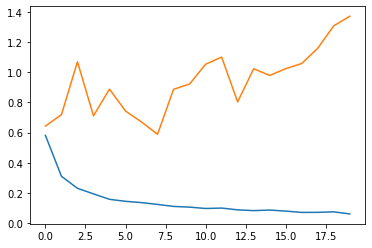

In [333]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [334]:
y_pred_probab = model.predict(X_test_cnn)

In [335]:
y_pred = np.argmax(y_pred_probab, axis = 1)

In [336]:
max(y_pred+1)

4

In [337]:
Y_test_cnn

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [338]:
from  sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, y_pred+1)

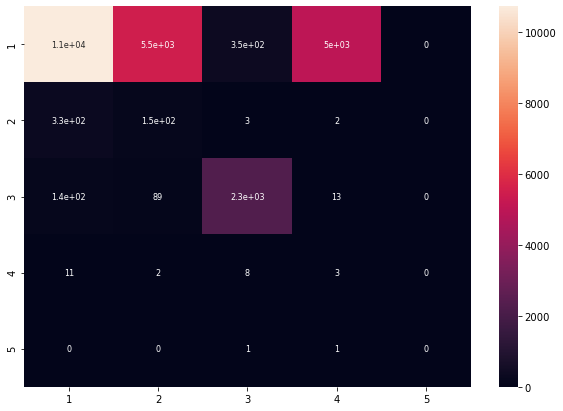

In [339]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})

In [293]:
cm

array([[16950,   152,  3113,  1379,     2],
       [  439,    33,     9,     3,     0],
       [  203,    44,  2247,    14,     0],
       [   12,     2,     8,     2,     0],
       [    0,     0,     2,     0,     0]], dtype=int64)